In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[Google policy update requires prominent disclosures in AI-generated content for political ads.](https://searchengineland.com/google-disclosure-rules-synthetic-content-political-ads-443868)

___

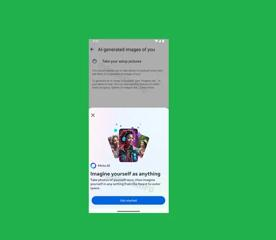

[WhatsApp tests AI selfie avatar generator](https://www.socialmediatoday.com/news/whatsapps-testing-ai-selfie-generator-tool/720536/) - Social Media Today

___

[GPT gone wild asking for fake funny Mexican names](https://www.reddit.com/r/ChatGPT/comments/1du1v5t/i_asked_chatgpt_for_a_middle_name_as_a_joke_for/)

___

[AI voice and eye scans improve diagnoses.](https://greekreporter.com/2024/07/03/ai-revolutionizes-disease-diagnosis-voice-eye-scans/)

___

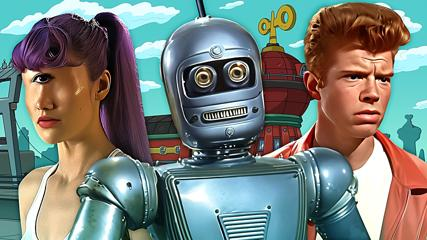

[Good news everyone! live action Futurama created with AI!](https://www.looper.com/1611151/ai-futurama-real-life-1950s-trailer/) - Looper

___

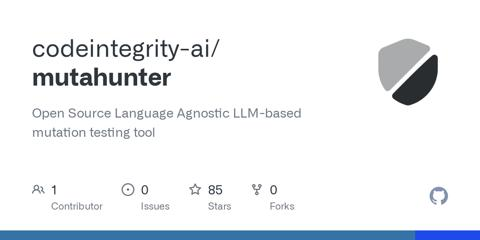

[Mutahunter AI makes testing more robust by introducing small variations into tests.](https://github.com/codeintegrity-ai/mutahunter) - GitHub

___

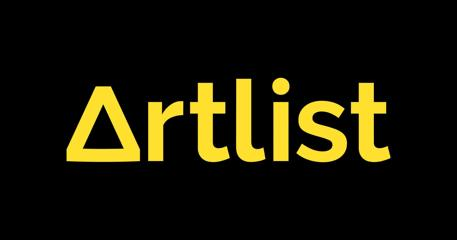

[Artlist adds AI powered video voiceovers.](https://petapixel.com/2024/06/24/popular-asset-marketplace-artlist-adds-ai-voiceover-generator/) - PetaPixel

___

[Kerfuffle over \\$70m geoscience AI project that sounds pretty cool, culminates in firing of society president.](https://www.science.org/content/article/chinese-ai-stirs-panic-european-geoscience-society)

___

[It's not so much that knowledge is cost-free, just that a lot of expertise becomes zero-marginal-cost once you train the model, similar to how it costs a fortune to make e.g. a blockbuster movie or Photoshop but then you can distribute infinite copies to billions of people practically for free.](https://www.axios.com/2024/07/03/ai-power-knowledge-cost-future)

___

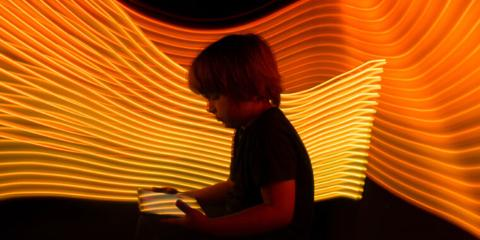

[AI trains on photos of kids whose parents post photos with strict privacy settings.](https://arstechnica.com/tech-policy/2024/07/ai-trains-on-kids-photos-even-when-parents-use-strict-privacy-settings/) - Ars Technica

___

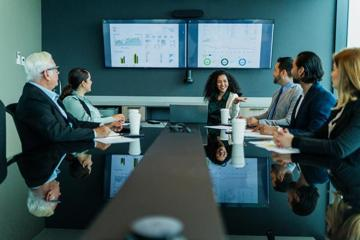

[AI for HR is a key test case for transparency, fairness, limits of Big Brother.](https://www.forbes.com/sites/forbeshumanresourcescouncil/2024/07/03/what-the-coming-ai-transparency-wave-means-for-hr/) - Forbes

___

[China leads in AI patents.](https://www.reuters.com/technology/artificial-intelligence/china-leading-generative-ai-patents-race-un-report-says-2024-07-03/)

___

[VC dealmaking picks up but still well below 2021. I can't even remember what people were investing in back then. The AI boom is more driven by bigcos spending 10s of billions on GPUs, data centers, chip factories. Like telcos dropping bucks on fiber buildout in dot-com era, could never have enough.](https://www.bloomberg.com/news/articles/2024-07-03/ai-startups-inject-some-life-into-vc-dealmaking-in-the-us)

___

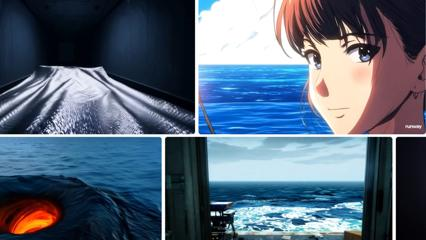

[Some more cool Runway Gen 3 examples.](https://indianexpress.com/article/technology/artificial-intelligence/runway-ai-gen-3-alpha-openai-sora-text-to-video-ai-9428074/) - The Indian Express

___

[Brazil tells Meta they can't train AI on users' personal data.](https://www.reuters.com/technology/artificial-intelligence/brazil-authority-suspends-metas-ai-privacy-policy-seeks-adjustment-2024-07-02/)

___

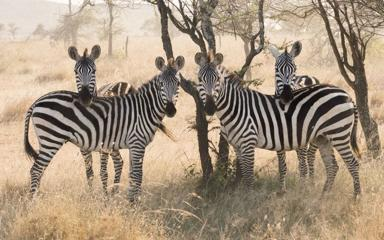

[An open source toolkit to identify individual wildlife creatures.](https://hackernoon.com/wildlifedatasets-an-open-source-toolkit-for-animal-re-identification-abstract-and-introduction)

___

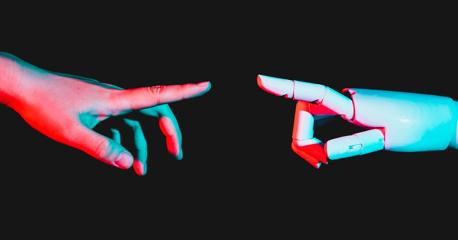

[Google sometimes ranks AI slop based on original reporting above the actual reporting.](https://www.wired.com/story/google-search-ai-spam-original-reporting-news-results/) - WIRED

___

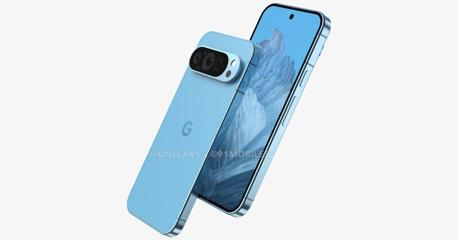

[Google Pixel has Recall-like feature that searches screenshots, but you have to trigger a picture and can turn the feature on and off.](https://www.theverge.com/2024/7/2/24190730/google-ai-pixel-phones-recall-like-feature) - The Verge

___

[Aaron Judge low-key having a better season than 2022, 3 days past the half-way mark, how 'bout that? King.](https://www.baseball-reference.com/players/j/ju..)

___

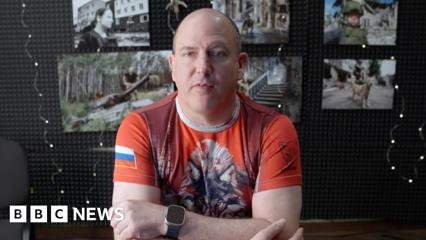

[AI-generated fake news from Moscow, aimed at Americans. 

Only a matter of time before Trump cites it the same way he cited stories about Nancy Pelosi admitting she was personally responsible for turning away troops to ensure rioters could storm the Capitol.](https://www.bbc.com/news/articles/c72ver6172do)

___

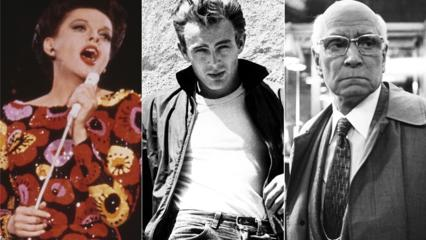

[ElevenLabs signs up dead actors.](https://variety.com/2024/biz/news/ai-judy-garland-james-dean-burt-reynolds-elevenlabs-reader-app-1236058829/) - Variety

___

[Code assistants that no one has heard of and don't have product-market-fit are getting massive valuations.](https://www.reuters.com/technology/artificial-intelligence/ai-coding-startup-magic-seeks-15-billion-valuation-new-funding-round-sources-say-2024-07-02/)

___

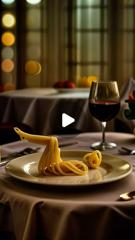

[Some more crazy AI animations -](https://www.instagram.com/gerdegotit/reel/C84Ddmbx5bR/) - Instagram

___

[After impressing with latest text-to-video model, Runway stumps for cash.](https://www.theinformation.com/articles/runway-an-ai-video-startup-in-talks-with-general-atlantic-for-4-billion-valuation-fundraise)

___

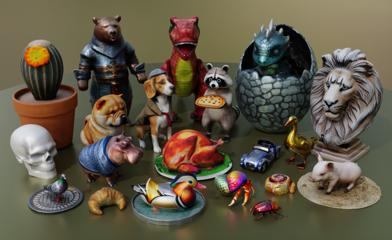

[Meta drops text-to-3d-model AI](https://venturebeat.com/ai/meta-drops-3d-gen-bomb-ai-powered-3d-asset-creation-at-lightning-speed/) - VentureBeat

___

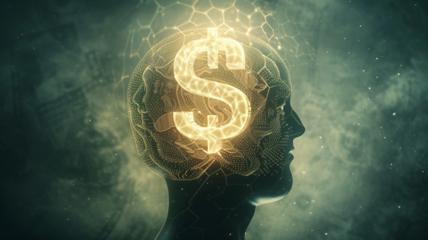

[A roundup of AI in finance. An area like investment research might be less affected because you probably don't make a lot of analysts redundant, but the staff are going to be using a lot of AI tools to be a lot more productive.](https://venturebeat.com/ai/gen-ai-takes-over-finance-the-leading-applications-and-their-challenges/) - VentureBeat

___

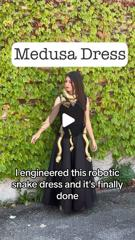

[Google engineer makes crazy Medusa snake dress. www.instagram.com/shebuildsrob... Isn't easier to just just write prompts and have AI make nightmare fuel?](https://www.instagram.com/shebuildsrobots/reel/C80S_L4xB_B/) - Instagram

___

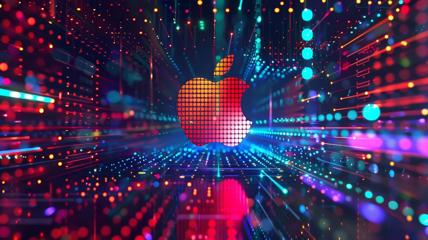

[Apple posted their 4M model on Huggingface.](https://venturebeat.com/ai/apple-just-launched-a-public-demo-of-its-4m-ai-model-heres-why-its-a-big-deal/) - VentureBeat

___

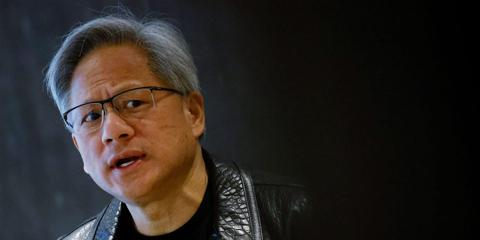

[Europe might force Nvidia to open up CUDA, their all-important software layer that all AI tool stacks support seamlessly, and that only runs with Nvidia cards.](https://www.businessinsider.com/nvidia-secret-sauce-regulators-gpu-chips-jensen-huang-2024-7) - Business Insider

___

Google, remember Google? The guys Musk was so afraid would monopolize closed AI that he started OpenAI? Those guys released a GPT-4 adjacent model you can run on your MacBook. 

Meanwhile Grok is nowhere to be seen on AI leaderboards, open-source or otherwise.

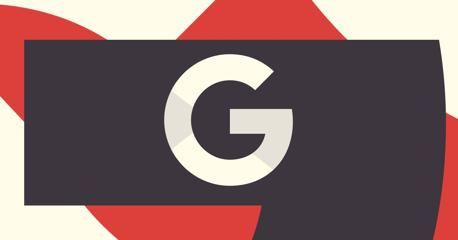

[Google's carbon footprint rises, despite promises to shrink it.](https://www.theverge.com/2024/7/2/24190874/google-ai-climate-change-carbon-emissions-rise) - The Verge

___

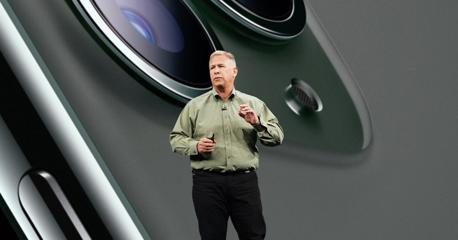

[Phil Schiller to join OpenAI board in 'observer' role following Apple's ChatGPT deal.](https://9to5mac.com/2024/07/02/apple-phil-schiller-openai-board-observer/) - 9to5Mac

___

[FT gently mocks 184-page report that predicts 8m humanoid robots by 2040.](https://www.ft.com/content/fcc917ab-5b12-4222-901a-6922f1d6894a)

___

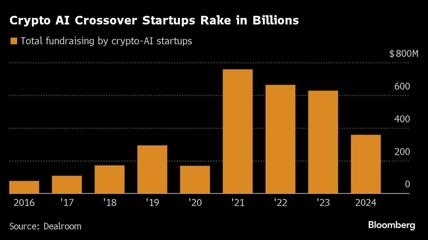

[Open source AI dev platform raises \\$85m](https://finance.yahoo.com/news/ai-crypto-startup-raises-85-130000553.html) - Yahoo Finance

___

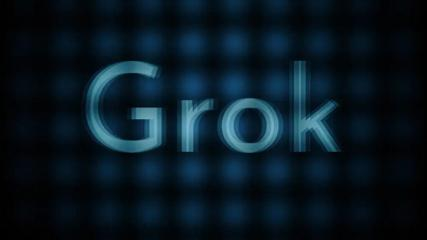

[Musk says Grok 2 in August, Grok 3 by end of year, training on 100,000 Nvidia GPUs.](https://www.neowin.net/news/elon-musk-says-grok-2-due-in-august-grok-3-by-end-of-year/) - Neowin

___

['Bitcoin mining giant' tests limits of AI frenzy with grab at a \\$16b IPO](https://coingape.com/europe-bitcoin-mining-giant-northern-data-eyes-a-us-ipo-with-ai-move/)

___

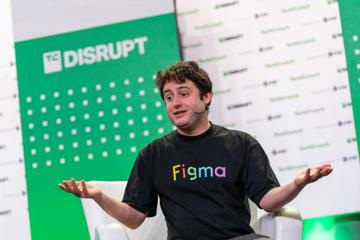

[Figma disables its AI design feature that appeared to be ripping off Apple's Weather app](https://techcrunch.com/2024/07/02/figma-disables-its-ai-design-feature-that-appeared-to-be-ripping-off-apples-weather-app/) - TechCrunch

___

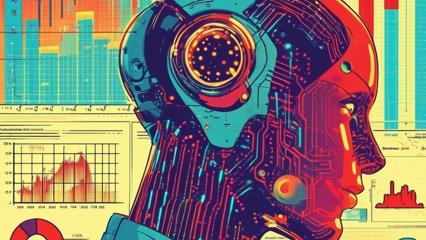

[6 bit questions about AI.](https://venturebeat.com/ai/from-agi-to-roi-the-6-ai-debates-shaping-enterprise-strategy-in-2024/) - VentureBeat

___

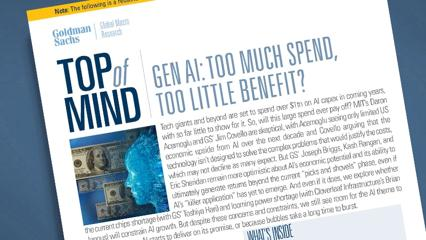

[Goldman Sachs on Gen AI: too much spend, too little benefit?](https://www.goldmansachs.com/intelligence/pages/gen-ai-too-much-spend-too-little-benefit.html) - Goldman Sachs

___

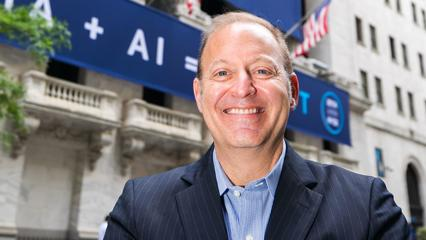

[AI economic indicator combines high-frequency and low-frequency data in an opaque and useless way.](https://www.cnbc.com/2024/07/01/a-new-index-is-using-ai-tools-to-measure-us-economic-growth-in-a-broader-way.html#:~:text=do%20the%20job.-,The%20Zeta%20Economic%20Index%2C%20launched%20Monday%2C%20uses%20generative%20AI%20to,a%20separate%20measure%20on%20stability) - CNBC

___

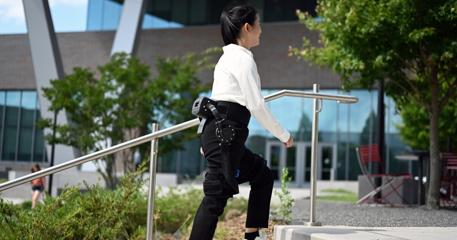

[Lower-body AI exoskeleton trained on videos assists people  walking, running, climbing stairs, reduces energy needed by 13% to 24%.](https://www.wunc.org/news/2024-06-28/nc-state-ai-robotic-exoskeleton-simulation) - WUNC

___

[Steve Ballmer is now richer than Bill Gates, as Ballmer kept his Microsoft stock while Gates heeded Buffett's advice to diversify. Fun fact, Ballmer margined his stock and levered up when Microsoft Word was delayed in the 80s and the stock took a big hit, increased his net worth maybe 30%.](https://www.bloomberg.com/news/articles/2024-07-01/ballmer-is-richer-than-gates-a-first-for-microsoft-billionaires)

___

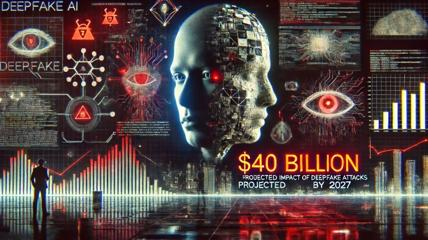

[Enterprises are unprepared for a wave of deepfake identity fraud.](https://venturebeat.com/security/deepfakes-will-cost-40-billion-by-2027-as-adversarial-ai-gains-momentum/) - VentureBeat

___

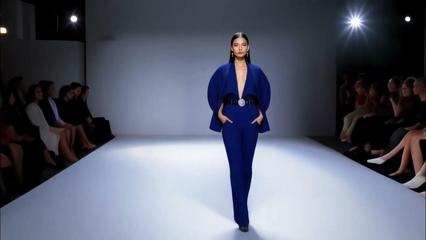

[Motorola / Lenovo positions phone as a fashion item with AI-generated ad.](https://www.youtube.com/watch?v=CSfw_NjqQ2o) - YouTube

___

[Rehabilitate or reprogram criminals by implanting false memories. wut?](https://wired.me/technology/cognify-prison-of-future/)

___

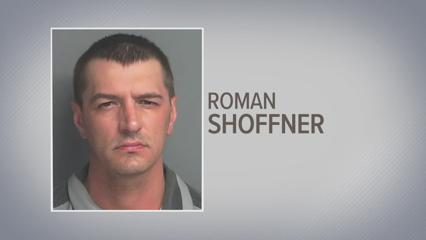

[Texas man catches a child porn charge over deepfake.](https://www.khou.com/article/news/crime/texas-man-child-pornography-charges-artificial-intelligence/285-53d74767-dea7-42b9-b651-f0cd0712ebc9) - khou.com

___

[Ukraine, the Silicon Valley of killer robots.](https://www.nytimes.com/2024/07/02/technology/ukraine-war-ai-weapons.html)

___

[YouTube implements process to take down AI deepfakes.](https://www.theregister.com/2024/07/02/youtube_deepfake_privacy_rules/)

___

[Figure posts video of its robot, says it's up and running at US BMW plant.](https://x.com/Figure_robot/status/1807814184299831749) - X (formerly Twitter)

___

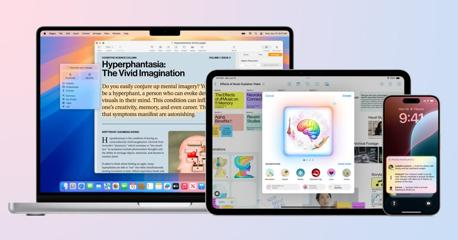

[Apple still in talks with Google and also Anthropic for AI integration, probably not Meta](https://9to5mac.com/2024/07/01/apple-google-gemini-chatbot/) - 9to5Mac

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 3, 14, 13, 57, 763000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-02 04:14:54.804496
